## Setup

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
os.makedirs("../figures/dpapt", exist_ok=True)
stats_df = lambda experiment: f"../results/dpapt/{experiment}/stats.csv"
indiv_hd_df = lambda experiment: f"../results/dpapt/{experiment}/indiv_hd.csv"
query_df = lambda experiment: f"../results/dpapt/{experiment}/query_distortion.csv"

In [3]:
basic_stats = pd.read_csv(stats_df("basic"))
basic_stats["t_span"] = basic_stats["tu"] - basic_stats["tl"] + 1

In [4]:
pp_center = {"sample": False, "uniform": False}
pp_uniform = {"sample": False, "uniform": True}

In [5]:
def filter_df(df, filters):
    df_filtered = df.copy()
    for col, val in filters.items():
        if isinstance(val, list):
            df_filtered = df_filtered[df_filtered[col].isin(val)]
        else:
            df_filtered = df_filtered[df_filtered[col] == val]
    return df_filtered

In [6]:
def lineplot(
    data, 
    x_col, 
    y_col, 
    weights_col=None,
    hue_col=None, 
    title="", 
    xlabel="x",
    x_ticks=None,
    y_ticks=None,
    estimator=None,
    ylabel="y", 
    legend_title=None, 
    ax=None, 
    out_file=None
):
    sns.set_theme(style="whitegrid")
    sns.set_palette("colorblind")
    sns.set_context("paper")
    if ax is None:
        _, ax = plt.subplots()
    sns.lineplot(data=data, x=x_col, y=y_col, weights=weights_col, hue=hue_col, estimator=estimator, ax=ax, markers=True, dashes=False)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if hue_col:
        ax.legend(title=legend_title)
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
    if y_ticks is not None:
        ax.set_yticks(y_ticks)
    ax.grid(True)
    plt.tight_layout()
    if out_file is not None:
        plt.savefig(f"../figures/dpapt/{out_file}.pdf", format="pdf", bbox_inches="tight")

In [7]:
def violinplot(
    data, 
    x_col, 
    y_col, 
    hue_col=None,
    title="", 
    xlabel="x",
    x_ticks=None,
    y_ticks=None,
    ylabel="y", 
    legend_title=None, 
    ax=None, 
    out_file="vlnplot"
):
    sns.set_theme(style="whitegrid")
    sns.set_palette("colorblind")
    sns.set_context("paper")
    if ax is None:
        _, ax = plt.subplots()
    sns.violinplot(data=data, x=x_col, y=y_col, hue=hue_col, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if hue_col:
        ax.legend(title=legend_title)
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
    if y_ticks is not None:
        ax.set_yticks(y_ticks)
    ax.grid(True)
    plt.tight_layout()
    plt.savefig(f"../figures/dpapt/{out_file}.pdf", format="pdf", bbox_inches="tight")

## Output Data of DPAPT

DPAPT publishes a private synopsis consisting of trajectories over **cells** rather than precise points. Each trajectory produced by DPAPT is a sequence of cells, where each cell models some uncertainty of the trajectory at the given time.

Because the sanitized database operates over cells, **post-processing** is necessary to derive point-based trajectories that can be meaningfully compared against the original dataset. Post-processing translates each area into a representative point trajectory, enabling the use of traditional spatial utility metrics.

In this section, we restrict ourselves to the case where no clustering is applied, and therefore each area consists of exactly one cell. We consider two post-processing strategies:

- **Centroid Replacement**:
    Each cell is replaced by its geometric center. The resulting trajectory is fully deterministic, but does not model the spatial uncertainty inherent in the cell.

- **Uniform Sampling**:  
    For each cell, a point is sampled uniformly at random from the cell's interior. This introduces randomness, but captures the spatial uncertainty introduced by the DPAPT mechanism, **under the assumption of uniformity**.





## Utility Metrics
Following post-processing, we apply different utility metrics to assess the quality of the published database relative to the original one.


- **Euclidean Distance between Trajectories**
    
    The euclidean distance is restricted to trajectories having the same length.
    We consider the **pairwise euclidean distance** that computes the euclidean distance between trajectories points for each time step and computes the euclidean distance again on the resulting vector of pairwise distances.
    $$
    d_2^{\text{pair}}(T, T') = || ( ||p_1 - p_1'||_2, \dots, ||p_n - p_n'||_2) ||_2.
    $$
    By transforming a trajectory $T \in \{\mathbb{R} \times \mathbb{R}\}^t$ of length $t$ into a single $2t$ dimensional point $T^x \in \mathbb{R}^{2t}$ by *flattening* the coordinate tuples, the euclidean distance on $\mathbb{R}^{2t}$ under this transformation is equivalent to the euclidean distance on $\{\mathbb{R} \times \mathbb{R}\}$.

    In the following we write $||T - T'||_2$ as the euclidean distance of the flattened trajectories $T, T'$.

- **Comparing Distances of Trajectories with Different Lengths**

    When comparing trajectories of different lengths using Euclidean distance, care must be taken to ensure comparability. Longer trajectories naturally accumulate more error due to having more spatial points. As such, the *raw* Euclidean distance between flattened trajectories is not suitable for comparing utility across runs involving different time intervals.

    To address this, we consider the well-known **mean squared error (MSE)** formulation. For two trajectories $ T, T' \in (\mathbb{R} \times \mathbb{R})^t $, flattened to $ T^x, T'^x \in \mathbb{R}^{2t} $, the MSE is given by:
    $$
    \text{MSE}(T, T') = \frac{1}{2t} \| T^x - T'^x \|_2^2
    $$
    where $ 2t $ is the total number of coordinates. However, the MSE is expressed in squared units (e.g., metres squared), which can be difficult to interpret directly.

    To obtain a meaningful, unit-consistent distance measure, we take the square root of the MSE:
    $$
    \text{RMSE}(T, T') = \sqrt{ \frac{1}{2t} \| T^x - T'^x \|_2^2 } = \frac{ \| T^x - T'^x \|_2 }{ \sqrt{2t} }
    $$
    This **root mean squared error (RMSE)** corresponds to the **average L2 deviation per coordinate** and is expressed in the same units as the coordinate space (e.g., metres). It provides an interpretable and scale-consistent way of comparing distances between trajectories of varying lengths.

    We therefore use:
    $$
    d^{\text{norm}}(T, T') = \frac{ \| T - T' \|_2 }{ \sqrt{2t} }
    $$
    as the default normalised distance throughout this work, where $ T $ and $ T' $ are flattened trajectories. This allows us to compare distances meaningfully across time intervals and privacy budgets.



- **Hausdorff Distance**:

    Between to trajectory databases $D, D'$ over $\mathbb{R}^2$ of length $t$, we can calculate for each trajectory in $D$ the distance to each trajectory in the other $D'$ and take the minimum of it.
    Taking the maximum from that set of minimal distances, yields the *directed Hausdorff distance*:
    $$
    HD_d(D, D') = \max_{T \in D} \min_{T' \in D'} || T - T' ||_2.
    $$
    Taking the maximum of both directions yields the *symmetric Hausdorff distance* (or just Hausdorff distance):
    $$
    HD(D, D') = \max{\{ HD_d(D, D'), HD_d(D', D) \}}
    $$


## Parameters of DPAPT

DPAPT accepts several parameters that influence the structure and quality of its output.

- **Time Interval**:
  
  The time interval `t_int = [t_l, t_u]` specifies the lower and upper time bounds for the trajectories in the supplied dataset.  
  For each input trajectory, DPAPT extracts the subtrajectory corresponding to this interval and attempts to reconstruct similar trajectories in the sanitized output.  
  Consequently, the published trajectories have length $ |t_u - t_l| + 1 $.  
  We refer to the variation of `t_int` as the **time interval range**.

- **Privacy Budget $\varepsilon$**:

  The parameter `eps` specifies the total privacy budget allocated to the execution of DPAPT.  
  As $\varepsilon$ increases, less noise is added during privatization, potentially improving the utility of the published data.

- **Post-Processing Strategy**:

  Post-processing specifies how areas (cells) in the output are converted into point trajectories.  
  Two strategies are considered:
  
  - `center`: replace each cell by its geometric center (deterministic).
  - `sample`: uniformly sample a point from within each cell (randomized).



## Parameter Evaluation

In the following, we investigate how the choices of time interval range, privacy budget, and post-processing strategy influence the utility of the output.



### Influence of Time Interval Range

We expect the influence of the time interval range to be significant due to the way DPAPT constructs sanitized databases.

At each time step, DPAPT must account for privacy leakage by injecting **fake trajectories**, proportionally to the number of trajectories accumulated up to the previous step.  
This recursive process leads to an **exponential growth of noise** over time.  
Consequently, we expect the overall utility to **decrease exponentially** as the time interval range increases.


#### Hausdorff

In [8]:
def hd_boxplot(df, ax=None, title=None):
    sns.boxplot(
        data=df,
        x="t_span",
        y="hd_norm",
        hue="eps",
        ax=ax,
        palette="colorblind"
    )
    if title is not None and ax is not None:
        ax.set_title(title)

In [4]:
indiv_hd = pd.read_csv(indiv_hd_df("basic"))
indiv_hd["t_span"] = indiv_hd["tu"] - indiv_hd["tl"] + 1
basic_stats["hd_norm"] = basic_stats["hausdorff"] / np.sqrt(2 * basic_stats["t_span"])
indiv_hd["indiv_hd_norm"] = indiv_hd["individual_hausdorff"] / np.sqrt(2 * indiv_hd["t_span"])

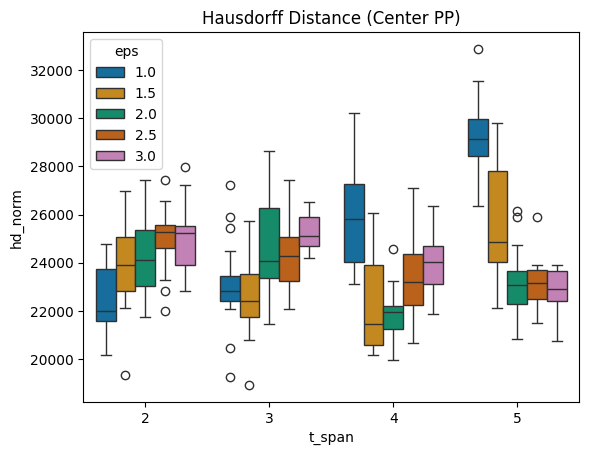

In [11]:
# fix_eps = {"eps": 1}
basic_t_range_center_pp = filter_df(basic_stats, {**pp_center})
hd_boxplot(basic_t_range_center_pp, ax=plt.gca(), title="Hausdorff Distance (Center PP)")
plt.show()

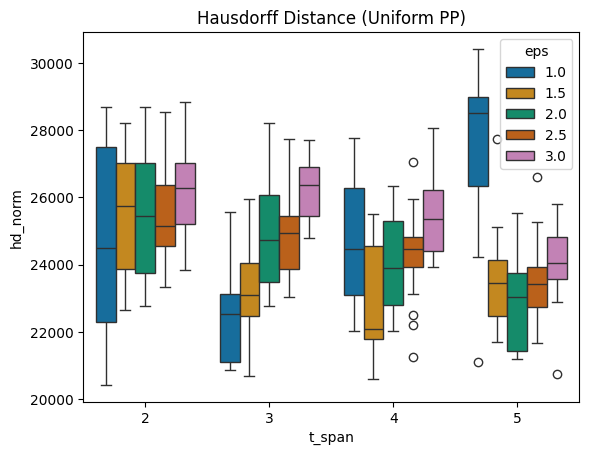

In [12]:
basic_t_range_uniform_pp = filter_df(basic_stats, {**pp_uniform})
hd_boxplot(basic_t_range_uniform_pp, ax=plt.gca(), title="Hausdorff Distance (Uniform PP)")
plt.show()

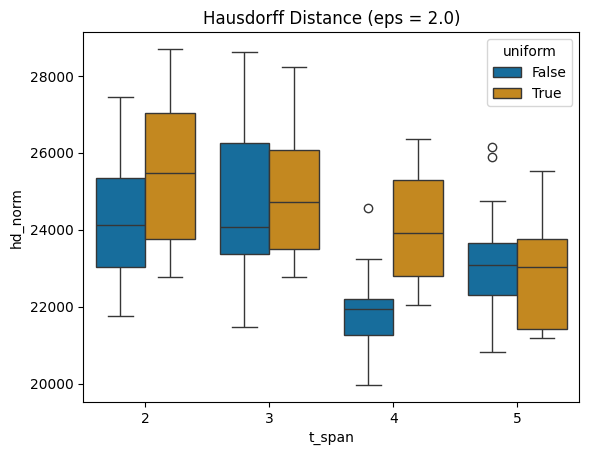

In [13]:
basic_hd_pp_both = pd.concat([basic_t_range_center_pp, basic_t_range_uniform_pp])
eps = 2.0
basic_hd_pp_both = filter_df(basic_hd_pp_both, {"eps": eps})
sns.boxplot(
    data=basic_hd_pp_both,
    x="t_span",
    y="hd_norm",
    hue="uniform",
    palette="colorblind",
)
plt.title(f"Hausdorff Distance (eps = {eps})")
plt.show()

The plot above shows the **normalized Hausdorff distance** between the original and published datasets for different time spans and privacy budgets, using the `center` post-processing strategy (cell centroid replacement).

We can summarize the following observations:

- **No consistent exponential utility degradation** with longer time spans:  
  While DPAPT introduces more noise over time, the normalized Hausdorff distance does not increase monotonically. In some cases, utility **improves** slightly with longer trajectories, which seems interesting.
  Still, the distance approached is considerably large, indicating that DPAPT produces trajectories with very low utility

- **Higher privacy budgets do not guarantee better utility:**
  Contrary to expectation, increasing $ \varepsilon $ does not consistently lead to lower error. This supports the earlier insight that **DPAPT’s internal mechanisms (e.g., grid refinement and prefix tree expansion)** can introduce more noise with higher $ \varepsilon $, reducing utility in some cases.

- **Normalized distances remain substantial**:  
  Across all settings, the normalized Hausdorff distances lie between 22–30 km, indicating that even with normalization, the privacy mechanism introduces significant spatial noise. This highlights the **inherent trade-off between privacy and accuracy**, and motivates further investigation into more effective post-processing and grid design strategies.

These findings show that utility under DPAPT is governed by more than just privacy budget and trajectory length.


#### Individual Hausdorf

To better understand the utility of DPAPT beyond worst-case outcomes, we visualize the **distribution** of trajectory errors using the *individual Hausdorff distance*, normalized by time span. Each violin plot shows the distribution of errors across all published trajectories, grouped by time span and privacy budget $ \varepsilon $, using the `center` post-processing strategy.

where the individual Hausdorff distance between a trajectory $T$ and a database $D$ is defined by:

$$
IndivHD(T, D) = \min_{T' \in D} || T - T' ||_2
$$

- compute IndivHD for every T in D_published

KeyboardInterrupt: 

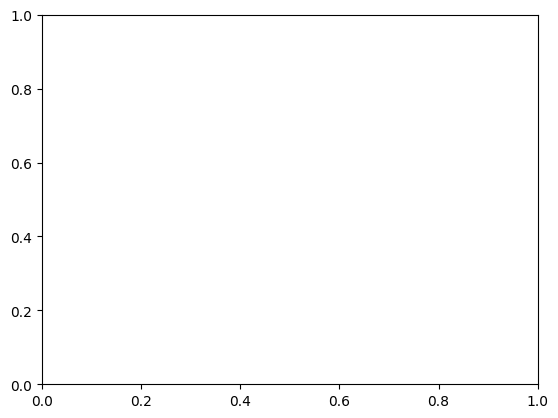

In [14]:
eps = [1.0, 2.0, 3.0]
basic_indiv_hd_pp_center = filter_df(indiv_hd, {"eps": eps, **pp_center})
expanded_indiv_hd = basic_indiv_hd_pp_center.loc[
    basic_indiv_hd_pp_center.index.repeat(basic_indiv_hd_pp_center["count"])
].reset_index(drop=True)
violinplot(
    data=expanded_indiv_hd,
    x_col="t_span",
    y_col="indiv_hd_norm",
    hue_col="eps",
    title=f"Individual Hausdorff Distance Normalized by Time Span for different privacy budgets",
    xlabel="Time Span",
    x_ticks=basic_indiv_hd_pp_center["t_span"].unique(),
    ylabel="Normalized Individual Hausdorff Distance (meters)",
    legend_title="Epsilon",
    ax=plt.gca(),
    out_file="basic_indiv_hd_pp_center"
)
plt.show()

We can conclude with the following oberservations

- **Consistent degradation with higher privacy budgets**:  
  Contrary to the expected behavior of differential privacy mechanisms, higher values of  $\varepsilon $ (i.e., lower privacy, less noise) do **not** lead to better utility. In fact, DPAPT often performs **worse** at $ \varepsilon = 3.0 $ than at  $\varepsilon = 1.0 $, especially as the time span increases.

- **Distribution confirms non-monotonicity seen in aggregate metrics**:  
  This distributional view supports and sharpens the insight gained from the previous normalized Hausdorff plots — utility does not improve monotonically with increased privacy budget. The effect becomes more pronounced for longer time intervals.

- **Broad and heavy-tailed error distributions**:  
  For each privacy budget and time span, the error distribution is wide and includes **outliers** with high individual distances. This suggests that while *some* trajectories are reconstructed reasonably well, the predominant fraction experience substantial deviation.

### Number of "Meaningful" Trajectories

Since the previous results showed the counterintuitive trend that increasing the privacy budget does not necessarily lead to improved average utility, we now investigate whether **the absolute number of high-quality (i.e., meaningful) trajectories increases** with $\varepsilon $.

We define a trajectory as *meaningful* if its normalized individual Hausdorff distance falls below the 15th percentile of the overall distribution. For each privacy budget and time span, we count the number of trajectories that meet this criterion.

/tmp/ipykernel_1312821/2348850084.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df["indiv_hd_norm"] < distance_thresh).mul(df["count"]).sum())


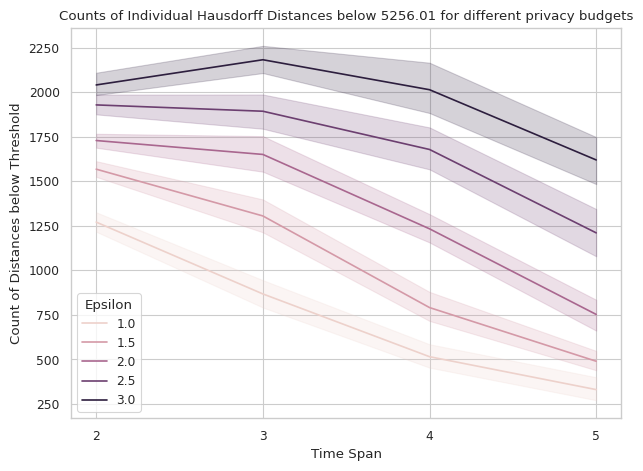

In [ ]:
basic_indiv_hd_pp_center = filter_df(indiv_hd, {**pp_center})
distance_thresh = basic_indiv_hd_pp_center["indiv_hd_norm"].quantile(0.15)

meaningful_counts = (
    basic_indiv_hd_pp_center
    .groupby(["run", "t_span", "eps"], group_keys=False)
    .apply(lambda df: (df["indiv_hd_norm"] < distance_thresh).mul(df["count"]).sum())
    .reset_index(name="count_below_thresh")
)
lineplot(
    data=meaningful_counts,
    x_col="t_span",
    y_col="count_below_thresh",
    estimator="mean",
    hue_col="eps",
    title=f"Counts of Individual Hausdorff Distances below {distance_thresh:.2f} for different privacy budgets",
    xlabel="Time Span",
    x_ticks=meaningful_counts["t_span"].unique(),
    ylabel="Count of Distances below Threshold",
    legend_title="Epsilon",
    ax=plt.gca(),
    out_file="basic_indiv_hd_pp_center_count"
)
plt.show()

**Key observations:**

- **Higher privacy budgets yield more meaningful trajectories**:  
  Despite DPAPT performing worse on average at higher  $\varepsilon $, the *absolute number* of trajectories with low error increases consistently. This supports the hypothesis that higher  $\varepsilon$ enables the mechanism to retain more real signal — even if the relative proportion of noise also increases.

- **Absolute counts peak around time span = 3, then decline**:  
  As time span grows, noise accumulates, but for intermediate lengths the mechanism can still generate a relatively high number of accurate trajectories. For longer time spans, fake trajectories and error propagation begin to dominate again.
  The increase in meaningfulness potentially comes from the smoothing effect of the RMSE.

This analysis shows that evaluating only worst-case or average errors can obscure important trends. Looking at the **absolute count of useful output** gives a richer picture of how privacy and time interval settings affect practical utility in DPAPT.

## Fixing Increasing Universe Size

In [ ]:
fix_usize = pd.read_csv(stats_df("eps_agnostic"))
fix_usize["t_span"] = fix_usize["tu"] - fix_usize["tl"] + 1
fix_usize["hd_norm"] = fix_usize["hausdorff"] / np.sqrt(2 * fix_usize["t_span"])

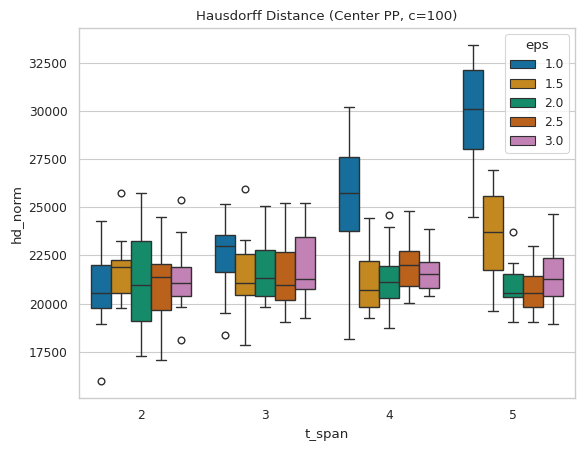

In [ ]:
c = 100
fix_usize_c_center_pp = filter_df(fix_usize, {"c": c, **pp_center})
hd_boxplot(fix_usize_c_center_pp, ax=plt.gca(), title="Hausdorff Distance (Center PP, c=100)")
plt.show()

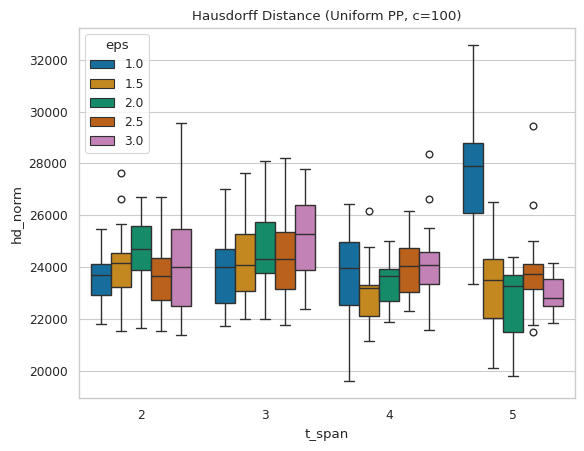

In [ ]:
fix_usize_c_uniform_pp = filter_df(fix_usize, {"c": c, **pp_uniform})
hd_boxplot(fix_usize_c_uniform_pp, ax=plt.gca(), title="Hausdorff Distance (Uniform PP, c=100)")
plt.show()

In [9]:
fix_usize_indiv_hd = pd.read_csv(indiv_hd_df("eps_agnostic"))
fix_usize_indiv_hd["t_span"] = fix_usize_indiv_hd["tu"] - fix_usize_indiv_hd["tl"] + 1
fix_usize_indiv_hd["indiv_hd_norm"] = fix_usize_indiv_hd["individual_hausdorff"] / np.sqrt(2 * fix_usize_indiv_hd["t_span"])

expanded_indiv_hd = fix_usize_indiv_hd.loc[
    fix_usize_indiv_hd.index.repeat(fix_usize_indiv_hd["count"])
].reset_index(drop=True)

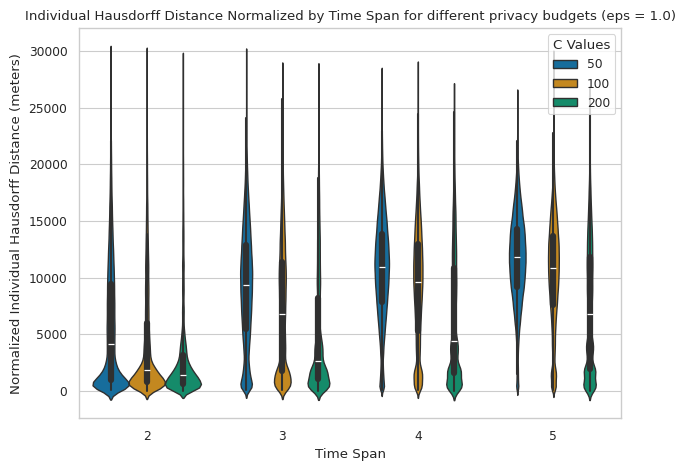

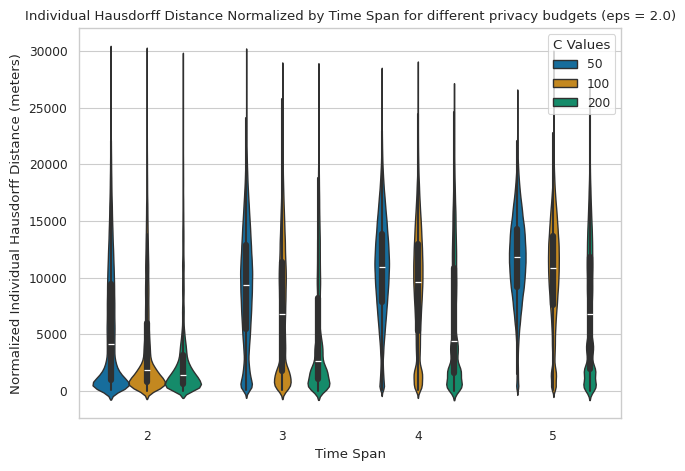

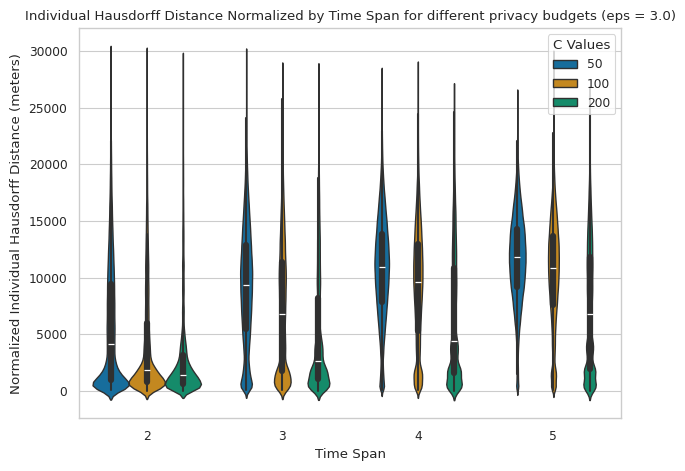

In [ ]:
filtered = filter_df(expanded_indiv_hd, pp_center)
for eps in [1.0, 2.0, 3.0]:
    filtered_eps = filter_df(filtered, ({"eps": eps}))
    sns.violinplot(
        data=expanded_indiv_hd,
        x="t_span",
        y="indiv_hd_norm",
        hue="c",
        palette="colorblind",
    )
    plt.title(f"Individual Hausdorff Distance Normalized by Time Span for different privacy budgets (eps = {eps})")
    plt.xlabel("Time Span")
    plt.ylabel("Normalized Individual Hausdorff Distance (meters)")
    
    plt.legend(title="C Values")
    plt.tight_layout()
    plt.show()

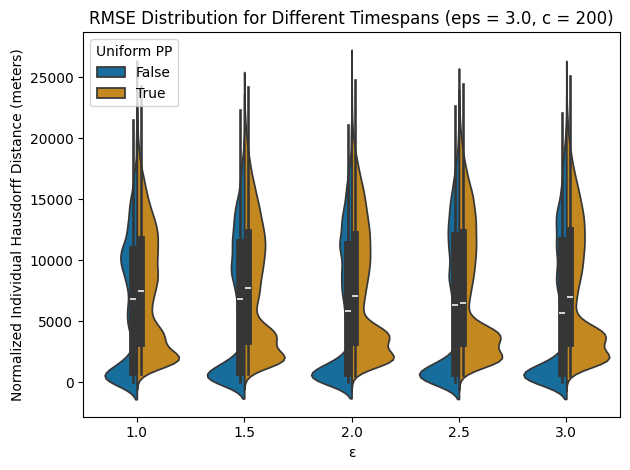

In [12]:
t_span = 5
c = 200
filtered = filter_df(expanded_indiv_hd, {"t_span": t_span, "c": c})
sns.violinplot(
    data=filtered,
    x="eps",
    y="indiv_hd_norm",
    hue="uniform",
    split=True,
    palette="colorblind",
)

plt.title(f"RMSE Distribution for Different Timespans (eps = {eps}, c = {c})")
plt.xlabel("ε")
plt.ylabel("Normalized Individual Hausdorff Distance (meters)")
plt.legend(title="Uniform PP")
plt.tight_layout()
plt.show()

In [19]:
cluster_stats = pd.read_csv(stats_df("cluster"))
cluster_stats["t_span"] = cluster_stats["tu"] - cluster_stats["tl"] + 1
cluster_stats["hd_norm"] = cluster_stats["hausdorff"] / np.sqrt(2 * cluster_stats["t_span"])

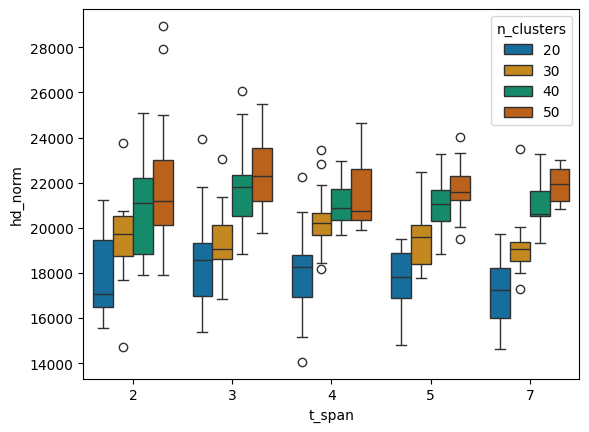

In [42]:
cluster_n = filter_df(cluster_stats, {"eps": 6.0})
sns.boxplot(
    data=cluster_n,
    x="t_span",
    y="hd_norm",
    hue="n_clusters",
    palette="colorblind"
)
plt.show()

In [43]:
cluster_idvhd = pd.read_csv(indiv_hd_df("cluster"))
cluster_idvhd["t_span"] = cluster_idvhd["tu"] - cluster_idvhd["tl"] + 1
cluster_idvhd["indiv_hd_norm"] = cluster_idvhd["individual_hausdorff"] / np.sqrt(2 * cluster_idvhd["t_span"])
expanded_indiv_hd = cluster_idvhd.loc[
    cluster_idvhd.index.repeat(cluster_idvhd["count"])
].reset_index(drop=True)

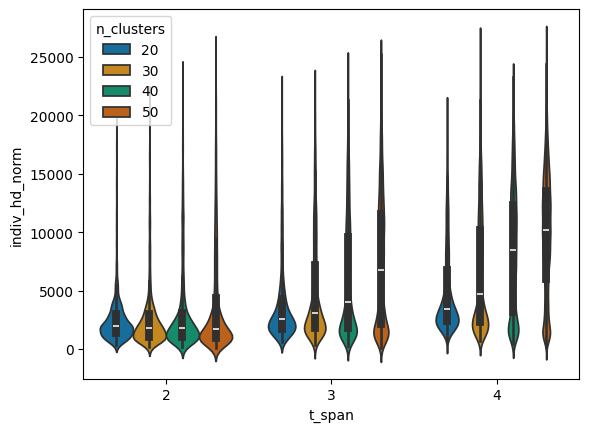

In [ ]:
cluste_idvhd_n = filter_df(expanded_indiv_hd, {"eps": 2.0, "t_span": [2, 3, 4]})
sns.violinplot(
    data=cluste_idvhd_n,
    x="t_span",
    y="indiv_hd_norm",
    hue="n_clusters",
    palette="colorblind",
)
plt.show()

In [55]:
cluster_qd = pd.read_csv(query_df("cluster"))
cluster_qd["t_span"] = cluster_qd["tu"] - cluster_qd["tl"] + 1
cluster_qd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036800 entries, 0 to 1036799
Data columns (total 20 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1036800 non-null  int64  
 1   run                 1036800 non-null  int64  
 2   eps                 1036800 non-null  float64
 3   tl                  1036800 non-null  int64  
 4   tu                  1036800 non-null  int64  
 5   n_clusters          1036800 non-null  int64  
 6   do_filter           1036800 non-null  bool   
 7   sample              1036800 non-null  bool   
 8   uniform             1036800 non-null  bool   
 9   c                   1036800 non-null  int64  
 10  f_m1                1036800 non-null  object 
 11  f_m2                1036800 non-null  object 
 12  query_run           1036800 non-null  int64  
 13  t_range             1036800 non-null  int64  
 14  radius              1036800 non-null  float64
 15  psi_distortion_

In [111]:
cluster_qd_n = filter_df(cluster_qd, {"n_clusters": [20, 40]})

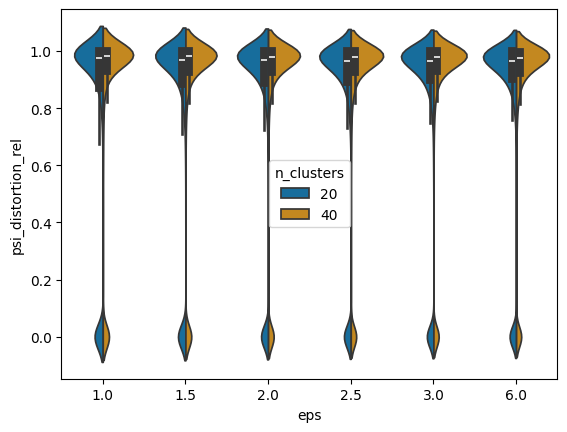

In [112]:
sns.violinplot(
    data=cluster_qd_n,
    x="eps",
    y="psi_distortion_rel",
    hue="n_clusters",
    split=True,
    palette="colorblind",
)
plt.show()